In [136]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os
import time

# 지도 데이터 분석 라이브러리
import fiona
import geopandas

# 데이터 분석 라|이브러리
import pandas as pd
import numpy as np

# 데이터 시각화 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import style
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import fontawesomefree as fa
import pydeck

# 데이터 분리
from sklearn.model_selection import train_test_split

# 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler

# 데이터 샘플링
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# 머신러닝
import xgboost
import catboost
import lightgbm
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import ensemble
import optuna

# 모델 스코어링
from sklearn.metrics import f1_score

In [2]:
# matplotlib 한글 지원 폰트 설정
plt.rc("font", family="Malgun Gothic")

In [3]:
# 데이터 불러오기

sejong = geopandas.read_file('./dataset/전처리후/세종/merge_11.geojson', encoding='utf-8')
sejong = sejong[['geometry', 'lat', 'lng', '고저차', '인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '주차장수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]

daegu = geopandas.read_file('./dataset/전처리후/대구/merge_11.geojson', encoding='utf-8')
daegu = daegu[['geometry', 'lat', 'lng', '고저차', '인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '주차장수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]

daejeon = geopandas.read_file('./dataset/전처리후/대전/merge_11.geojson', encoding='utf-8')
daejeon = daejeon[['geometry', 'lat', 'lng', '고저차', '인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '주차장수', '교육연구시설', '주거지', '농축산업시설', '창고시설',
       '편의시설', '생산시설', '님비시설', '자동차관련시설', 'EV']]

In [4]:
# 인구수 = 0 & 충전소 = 0 인 타일 제거

sejong_pp = sejong.drop(sejong[(sejong['인구수']==0) & (sejong['EV']==0)].index)
daegu_pp = daegu.drop(daegu[(daegu['인구수']==0) & (daegu['EV']==0)].index)
daejeon_pp = daejeon.drop(daejeon[(daejeon['인구수']==0) & (daejeon['EV']==0)].index)

print('세종시 데이터 수 :', len(sejong))
print('세종시 인구수=0, 충전소=0인 타일:', len(sejong_pp), end='\n\n')

print('대전시 데이터 수 :', len(daejeon))
print('대전시 인구수=0인, 충전소=0인 타일:', len(daejeon_pp), end='\n\n')

print('대구시 데이터 수 :', len(daegu))
print('대구시 인구수=0인, 충전소=0인 타일:', len(daegu_pp))

sejong_pp_idx = sejong_pp.index

sejong_pp.reset_index(drop=True, inplace=True)
daejeon_pp.reset_index(drop=True, inplace=True)
daegu_pp.reset_index(drop=True, inplace=True)

세종시 데이터 수 : 47396
세종시 인구수=0, 충전소=0인 타일: 3391

대전시 데이터 수 : 92051
대전시 인구수=0인, 충전소=0인 타일: 12557

대구시 데이터 수 : 134846
대구시 인구수=0인, 충전소=0인 타일: 18830


In [5]:
# 정규화

scaler = MinMaxScaler()
sejong_pp_minmax = scaler.fit_transform(sejong_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']])
sejong_pp_minmax = pd.DataFrame(sejong_pp_minmax, columns=['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차'])
sejong_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']] = sejong_pp_minmax

daegu_pp_minmax = scaler.fit_transform(daegu_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']])
daegu_pp_minmax = pd.DataFrame(daegu_pp_minmax, columns=['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차'])
daegu_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']] = daegu_pp_minmax

daejeon_pp_minmax = scaler.fit_transform(daejeon_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']])
daejeon_pp_minmax = pd.DataFrame(daejeon_pp_minmax, columns=['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차'])
daejeon_pp[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']] = daejeon_pp_minmax

In [6]:
# 학습 / 검증 데이터 셋 분리

train_data = pd.concat([daegu_pp[daegu_pp.columns[3:-1]], daejeon_pp[daejeon_pp.columns[3:-1]]])
train_target = pd.concat([daegu_pp[daegu_pp.columns[-1]], daejeon_pp[daejeon_pp.columns[-1]]])

test_data = sejong_pp[sejong_pp.columns[3:-1]]
test_target = sejong_pp[sejong_pp.columns[-1]]

test_data.set_index(sejong_pp_idx, inplace=True)

In [7]:
### 랜덤언더샘플링
rus = RandomUnderSampler()
train_data_rus, train_target_rus = rus.fit_resample(train_data, train_target)

### 랜덤오버샘플링
ros = RandomOverSampler()
train_data_ros, train_target_ros = ros.fit_resample(train_data, train_target)

### 스모트오버샘플링
smote = SMOTE()
train_data_smote, train_target_smote = smote.fit_resample(train_data, train_target)

## 하이퍼파라미터 튜닝 ( Optuna )

### RandomForest

In [8]:
def rf_optuna(train_data, train_target, test_data, test_target, threshold):
    def rf_objective(trial):
        
        params = {
                    'max_depth' : trial.suggest_int('max_depth', 1, 10),
                    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
                    'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
                    "n_jobs": 4
            }

        clf = ensemble.RandomForestClassifier(**params, verbose=0)
        clf.fit(train_data, train_target)
        proba = clf.predict_proba(test_data)
        preds = (proba[:,1] >= threshold).astype('int')
        f1 = f1_score(test_target, preds)

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(rf_objective, n_trials=50, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")

    trial = study.best_trial

    print("  F1 : {}".format(trial.value))
    print("  Best hyperparameters: ")

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    clf = ensemble.RandomForestClassifier(**study.best_params)
    clf.fit(train_data, train_target)
    preds = clf.predict(test_data)
    
    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
        temp['pred'][idx] = preds[i]
    
    temp = select_EV(temp)
    f1 = f1_score(test_target, preds)
    
    return clf, temp, f1

### XGBoost

In [9]:
def xgb_optuna(train_data, train_target, test_data, test_target, threshold):
    def xgb_objective(trial):
        params = {
                #"objective": "multiclass",
                #"eval_metric":'mlogloss',
                "booster": 'gbtree',
                'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
                #"tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
                "n_jobs": 4,
                #"verbosity": 0,
                "max_depth": trial.suggest_int("max_depth", 4, 16),
                "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
                'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
                "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
                "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
                "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
                #'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),     
                'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
                "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
                # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
            }

        clf = xgboost.XGBClassifier(**params)
        clf.fit(train_data, train_target, verbose=0)
        proba = clf.predict_proba(test_data)
        preds = (proba[:,1] >= threshold).astype('int')
        f1 = f1_score(test_target, preds)

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(xgb_objective, n_trials=50, n_jobs=4, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")

    trial = study.best_trial

    print("  F1 : {}".format(trial.value))
    print("  Best hyperparameters: ")

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    clf = xgboost.XGBClassifier(**study.best_params)
    clf.fit(train_data, train_target)
    preds = clf.predict(test_data)
    
    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
        temp['pred'][idx] = preds[i]
    
    temp = select_EV(temp)
    f1 = f1_score(test_target, preds)
    
    return clf, temp, f1

### LightGBM

In [10]:
def lgbm_optuna(train_data, train_target, test_data, test_target, threshold):
    def lgbm_objective(trial):

        params = {
                #"objective": "multiclass",
                #"eval_metric":'mlogloss',
                "booster": 'gbtree',
                'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
                #"tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
                "n_jobs": 4,
                #"verbosity": 0,
                "max_depth": trial.suggest_int("max_depth", 4, 16),
                "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
                'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
                "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
                "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
                "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
                #'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),     
                'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
                "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
                # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
            }

        clf = lightgbm.LGBMClassifier(**params)
        clf.fit(train_data, train_target, verbose=0)
        proba = clf.predict_proba(test_data)
        preds = (proba[:,1] >= threshold).astype('int')
        f1 = f1_score(test_target, preds)

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(lgbm_objective, n_trials=50, n_jobs=4, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")

    trial = study.best_trial

    print("  F1 : {}".format(trial.value))
    print("  Best hyperparameters: ")

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    clf = lightgbm.LGBMClassifier(**study.best_params)
    clf.fit(train_data, train_target)
    preds = clf.predict(test_data)
    
    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
        temp['pred'][idx] = preds[i]
    
    temp = select_EV(temp)
    f1 = f1_score(test_target, preds)
    
    return clf, temp, f1

### CatBoost

In [11]:
def catb_optuna(train_data, train_target, test_data, test_target, threshold):
    def catb_objective(trial):

        params = {
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        'gpu_id':0,
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "n_jobs": 4,
        }


        clf = catboost.CatBoostClassifier(**params)
        clf.fit(train_data, train_target, verbose=0, early_stopping_rounds=100)
        proba = clf.predict_proba(test_data)
        preds = (proba[:,1] >= threshold).astype('int')
        f1 = f1_score(test_target, preds)

        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(catb_objective, n_trials=50, n_jobs=4, show_progress_bar=True)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")

    trial = study.best_trial

    print("  F1 : {}".format(trial.value))
    print("  Best hyperparameters: ")

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    clf = catboost.CatBoostClassifier(**study.best_params)
    clf.fit(train_data, train_target)
    preds = clf.predict(test_data)
    
    temp = sejong.copy()
    temp['pred'] = [0]*len(temp)
    for i, idx in enumerate(test_data.index):
        temp['pred'][idx] = preds[i]
    
    temp = select_EV(temp)
    f1 = f1_score(test_target, preds)
    
    return clf, temp, f1

## feature_importance

In [12]:
def feature_importance(clf):
    feature_importance = clf.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(test_data.columns)[sorted_idx])
    plt.title('Feature Importance')

## Arrange

In [13]:
def arrange(df):
    print('실제 충전소 수 :', len(df[df['EV']==1]))
    print('충전소가 있어야 한다고 분류한 타일 수 :', len(df[df['pred']==1]))
    print('recall score 실제 충전소가 맞는 지 맞춘 경우 :', len(df[(df['pred']==1) & (df['EV']==1)]), '/', len(df[df['EV']==1]))
    print('precision score 실제 충전소가 없는 곳을 맞춘 경우 :', len(df[(df['pred']==0) & (df['EV']==0)]), '/', len(df[df['EV']==0]))
    print('최적 입지 후보(실제론 없지만, 있어야 한다고 분류) :', len(df[(df['pred']==1) & (df['EV']==0)]), '/', len(df[df['EV']==0]))

## select_EV

In [14]:
def select_EV(df):
    df['FN'] = [0]*len(df)
    # EV == 0 & predict == 1 인 경우만 ['pred']에서 1로 설정
    idx = df[(df['EV'] == 0) & (df['pred'] == 1)].index
    for i in df[df['pred'] == 1].index:
        df['FN'].loc[i] = 0
    for i in idx:
        df['FN'].loc[i] = 1
        
    return df

## map_visualization

In [66]:
def map_visualization(df):
    fig, ax1 = plt.subplots(figsize=(15, 15))
    fig.set_facecolor('white')
    sejong['geometry'].plot(ax=ax1, color='gainsboro')
    sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
    df[df[df.columns[-1]]==1].plot(ax=ax1, column=df.columns[-1], color='red', aspect=1)
    ax1.set_axis_off()
    plt.show()

## 임계치 별 모델 학습

In [16]:
train_data_list = [train_data_rus, train_data_smote]
train_target_list = [train_target_rus, train_target_smote]

In [17]:
rf_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
rf_TP = [] # TrusPositive
rf_df = []
rf_clf = []
rf_FN = [] # FalseNegative = 최적입지

for i, (train_data, train_target) in enumerate(zip(train_data_list, train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        clf, df, f1 = rf_optuna(train_data, train_target, test_data, test_target, threshold)
        clear_output()
        rf_F1.append(f1)
        rf_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        rf_df.append(df)
        rf_clf.append(clf)
        rf_FN.append(len(df[df['FN']==1]))

In [ ]:
# XGBoost는 시간이 너무 오래걸려서 제외

'''
xgb_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
xgb_TP = [] # TruePositive
xgb_df = []
xgb_clf = []
xgb_FN = [] # FalseNegative = 최적입지

for i, (train_data, train_target) in enumerate(zip(train_data_list, train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        clf, df, f1 = xgb_optuna(train_data, train_target, test_data, test_target, threshold)
        clear_output()
        xgb_F1.append(f1)
        xgb_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        xgb_df.append(df)
        xgb_clf.append(clf)
        xgb_FN.append(len(df[df['FN']==1]))
'''

In [ ]:
lgbm_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
lgbm_TP = [] # TruePositive
lgbm_df = []
lgbm_clf = []
lgbm_FN = [] # FalseNegative = 최적입지

for i, train_data, train_target in enumerate(zip(train_data_list, train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        clf, df, f1 = lgbm_optuna(train_data, train_target, test_data, test_target, threshold)
        clear_output()
        lgbm_F1.append(f1)
        lgbm_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        lgbm_df.append(df)
        lgbm_clf.append(clf)
        lgbm_FN.append(len(df[df['FN']==1]))

In [ ]:
catb_F1 = [] # 0~9 : rus, 10~19 : ros, 20~29 : smote
catb_TP = [] # TruePositive
catb_df = []
catb_clf = []
catb_FN = [] # FalseNegative = 최적입지

for i, train_data, train_target in enumerate(zip(train_data_list, train_target_list)):
    for threshold in np.arange(0.1, 1, 0.1):
        clear_output()
        print('threshold :', threshold, '(', i, ' 번째 데이터 )')
        clf, df, f1 = catb_optuna(train_data, train_target, test_data, test_target, threshold)
        clear_output()
        catb_F1.append(f1)
        catb_TP.append(len(df[(df['pred']==1) & (df['EV']==1)]))
        catb_df.append(df)
        catb_clf.append(clf)
        catb_FN.append(len(df[df['FN']==1]))

## 모델 선정

### RandomForest

In [18]:
print(rf_F1)
print(rf_TP)
print(rf_FN)
rf_result = pd.DataFrame({'F1_score':rf_F1,
                            'TP':rf_TP,
                            'FN':rf_FN})
rf_result

[0.5907172995780591, 0.6295399515738499, 0.6374695863746958, 0.6336633663366337, 0.6370370370370371, 0.5995525727069351, 0.6339066339066339, 0.6336633663366337, 0.6354679802955665, 0.5737704918032787, 0.6027397260273973, 0.587737843551797, 0.6336633663366337, 0.6370370370370371, 0.6205250596658711, 0.6231884057971014, 0.62004662004662, 0.6308068459657702]
[140, 130, 131, 128, 129, 134, 129, 128, 129, 140, 132, 139, 128, 129, 130, 129, 133, 129]
[58, 7, 4, 0, 0, 37, 2, 0, 1, 72, 30, 58, 0, 0, 13, 9, 20, 4]


F1_score   TP  FN
0   0.590717  140  58
1   0.629540  130   7
2   0.637470  131   4
3   0.633663  128   0
4   0.637037  129   0
5   0.599553  134  37
6   0.633907  129   2
7   0.633663  128   0
8   0.635468  129   1
9   0.573770  140  72
10  0.602740  132  30
11  0.587738  139  58
12  0.633663  128   0
13  0.637037  129   0
14  0.620525  130  13
15  0.623188  129   9
16  0.620047  133  20
17  0.630807  129   4

In [24]:
idx = [0, 5, 9, 10, 11, 14, 16]

for i in idx:
    print('\n', i, '번째 모델')
    arrange(rf_df[i])


 0 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 198
recall score 실제 충전소가 맞는 지 맞춘 경우 : 140 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47062 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 58 / 47120

 5 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 171
recall score 실제 충전소가 맞는 지 맞춘 경우 : 134 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47083 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 37 / 47120

 9 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 212
recall score 실제 충전소가 맞는 지 맞춘 경우 : 140 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47048 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 72 / 47120

 10 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 162
recall score 실제 충전소가 맞는 지 맞춘 경우 : 132 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47090 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 30 / 47120

 11 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 197
recall score 실제 충전소가 맞는 지 맞춘 경우 : 139 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47062 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 58 / 47120

 14 번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고

RandomForest 모델들이 중복 추천한 격자 수 : 44


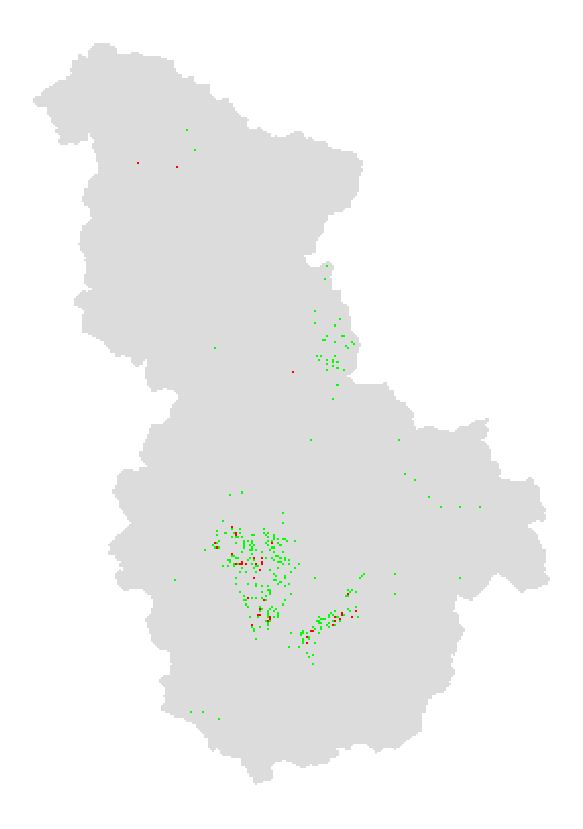

In [26]:
rf_sum = sejong.copy()
rf_sum['FN'] = rf_df[0]['FN'] + rf_df[5]['FN'] + rf_df[9]['FN'] + rf_df[10]['FN'] + rf_df[11]['FN'] + rf_df[14]['FN'] + rf_df[16]['FN']
print('RandomForest 모델들이 중복 추천한 격자 수 :', len(rf_sum[rf_sum['FN']>2]))

fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white')
sejong['geometry'].plot(ax=ax1, color='gainsboro')
sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
rf_sum[rf_sum['FN']>2].plot(ax=ax1, color='red', aspect=1)
ax1.set_axis_off()
plt.show()

In [27]:
rf_clf[5].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 809,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 205,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

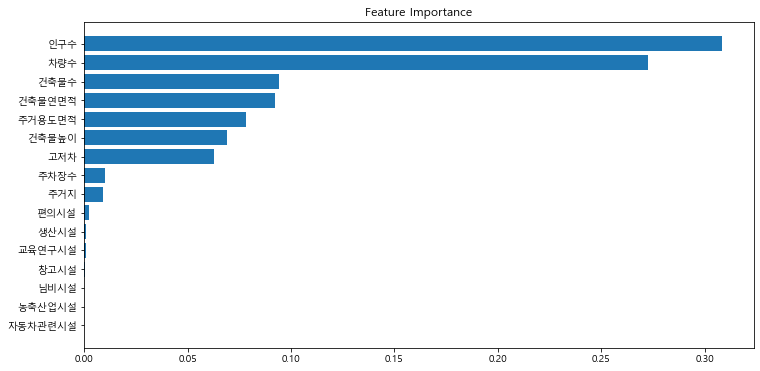

In [32]:
params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 809,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 205,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

clf = ensemble.RandomForestClassifier(**params)
clf.fit(train_data_rus, train_target_rus)
proba = clf.predict_proba(test_data)
preds = (proba[:,1] >= 0.6).astype('int')
feature_importance(clf)

### LightGBM

In [21]:
print(lgbm_F1)
print(lgbm_TP)
print(lgbm_FN)
lgbm_result = pd.DataFrame({'F1_score':lgbm_F1,
                            'TP':lgbm_TP,
                            'FN':lgbm_FN})
lgbm_result

[0.4057377049180328, 0.3841698841698842, 0.39585492227979274, 0.5172413793103448, 0.6040268456375839, 0.44685990338164255, 0.4386174016686532, 0.38906414300736075, 0.42630385487528344, 0.43337819650067294, 0.44592790387182907, 0.4475920679886685, 0.4396200814111262, 0.6308068459657702, 0.46476761619190404, 0.43665768194070076, 0.4387755102040817, 0.5112262521588947]
[198, 199, 191, 150, 135, 185, 184, 185, 188, 161, 167, 158, 162, 129, 155, 162, 172, 148]
[502, 561, 498, 154, 36, 367, 379, 490, 418, 306, 306, 272, 299, 4, 236, 304, 336, 155]


F1_score   TP   FN
0   0.405738  198  502
1   0.384170  199  561
2   0.395855  191  498
3   0.517241  150  154
4   0.604027  135   36
5   0.446860  185  367
6   0.438617  184  379
7   0.389064  185  490
8   0.426304  188  418
9   0.433378  161  306
10  0.445928  167  306
11  0.447592  158  272
12  0.439620  162  299
13  0.630807  129    4
14  0.464768  155  236
15  0.436658  162  304
16  0.438776  172  336
17  0.511226  148  155

In [23]:
print('3번째 모델')
arrange(lgbm_df[3])

print('\n4번째 모델')
arrange(lgbm_df[4])

print('\n13번째 모델')
arrange(lgbm_df[13])

print('\n17번째 모델')
arrange(lgbm_df[17])

3번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 304
recall score 실제 충전소가 맞는 지 맞춘 경우 : 150 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 46966 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 154 / 47120

4번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 171
recall score 실제 충전소가 맞는 지 맞춘 경우 : 135 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47084 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 36 / 47120

13번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 133
recall score 실제 충전소가 맞는 지 맞춘 경우 : 129 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47116 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 4 / 47120

17번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 303
recall score 실제 충전소가 맞는 지 맞춘 경우 : 148 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 46965 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 155 / 47120


LightGBM 모델들이 중복 추천한 격자 수 : 29


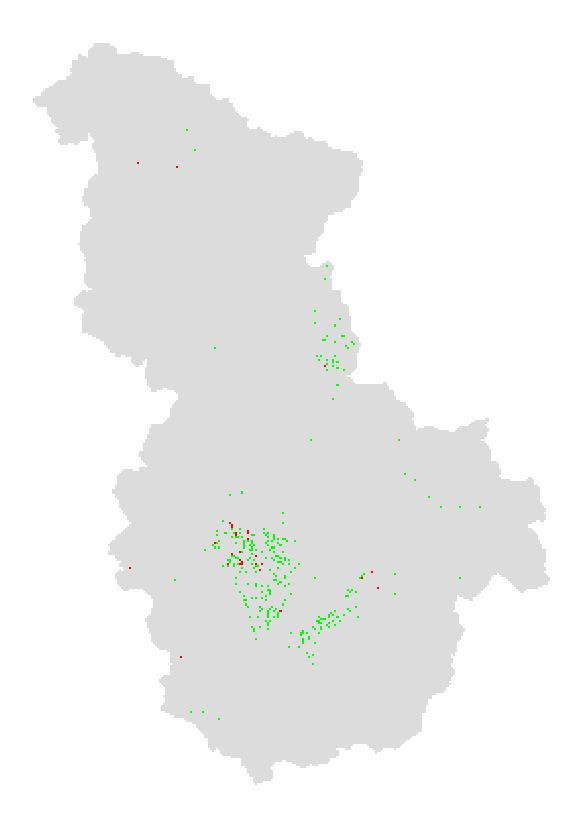

In [30]:
lgbm_sum = sejong.copy()
lgbm_sum['FN'] = lgbm_df[3]['FN'] + lgbm_df[4]['FN'] + lgbm_df[13]['FN'] + lgbm_df[17]['FN']

print('LightGBM 모델들이 중복 추천한 격자 수 :', len(lgbm_sum[lgbm_sum['FN']>2]))
fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white')
sejong['geometry'].plot(ax=ax1, color='gainsboro')
sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
lgbm_sum[lgbm_sum['FN']>2].plot(ax=ax1, color='red', aspect=1)
ax1.set_axis_off()
plt.show()

In [31]:
lgbm_clf[4].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.649805253699943,
 'importance_type': 'split',
 'learning_rate': 0.0001324457034893535,
 'max_depth': 9,
 'min_child_samples': 20,
 'min_child_weight': 8,
 'min_split_gain': 0.0,
 'n_estimators': 4800,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.5968297802559932,
 'reg_lambda': 0.11582887397582241,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'colsample_bylevel': 0.7916400635068106,
 'colsample_bynode': 0.8833222413319739,
 'gamma': 0.559424285340915}

[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: gamma


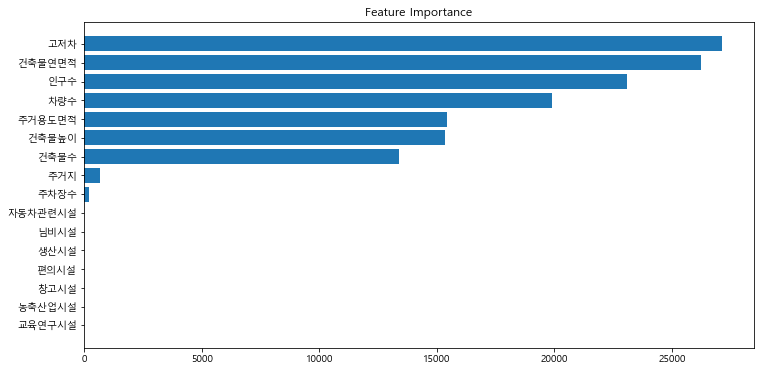

In [33]:
params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.649805253699943,
 'importance_type': 'split',
 'learning_rate': 0.0001324457034893535,
 'max_depth': 9,
 'min_child_samples': 20,
 'min_child_weight': 8,
 'min_split_gain': 0.0,
 'n_estimators': 4800,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.5968297802559932,
 'reg_lambda': 0.11582887397582241,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'colsample_bylevel': 0.7916400635068106,
 'colsample_bynode': 0.8833222413319739,
 'gamma': 0.559424285340915}

clf = lightgbm.LGBMClassifier(**params)
clf.fit(train_data_rus, train_target_rus, verbose=0)
proba = clf.predict_proba(test_data)
preds = (proba[:,1] >= 0.5).astype('int')
feature_importance(clf)

### CatBoost

In [102]:
print(catb_F1)
print(catb_TP)
print(catb_FN)
catb_result = pd.DataFrame({'F1_score':catb_F1,
                            'TP':catb_TP,
                            'FN':catb_FN})
catb_result

[0.45844504021447724, 0.5134228187919464, 0.6336633663366337, 0.6336633663366337, 0.6354679802955665, 0.5907172995780591, 0.6313253012048192, 0.5935483870967742, 0.6370370370370371, 0.5033557046979866, 0.5638095238095239, 0.5907172995780591, 0.6308068459657702, 0.6359223300970873, 0.5995525727069351, 0.513986013986014, 0.48231511254019294, 0.5008237232289952]
[171, 153, 128, 128, 129, 140, 131, 138, 129, 150, 148, 140, 129, 131, 134, 147, 150, 152]
[299, 167, 0, 0, 1, 58, 8, 51, 0, 170, 101, 58, 4, 5, 37, 149, 196, 179]


F1_score   TP   FN
0   0.458445  171  299
1   0.513423  153  167
2   0.633663  128    0
3   0.633663  128    0
4   0.635468  129    1
5   0.590717  140   58
6   0.631325  131    8
7   0.593548  138   51
8   0.637037  129    0
9   0.503356  150  170
10  0.563810  148  101
11  0.590717  140   58
12  0.630807  129    4
13  0.635922  131    5
14  0.599553  134   37
15  0.513986  147  149
16  0.482315  150  196
17  0.500824  152  179

In [90]:
print('5번째 모델')
arrange(catb_df[5])

print('\n7번째 모델')
arrange(catb_df[7])

print('\n11번째 모델')
arrange(catb_df[11])

print('\n14번째 모델')
arrange(catb_df[14])

5번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 198
recall score 실제 충전소가 맞는 지 맞춘 경우 : 140 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47062 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 58 / 47120

7번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 189
recall score 실제 충전소가 맞는 지 맞춘 경우 : 138 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47069 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 51 / 47120

11번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 198
recall score 실제 충전소가 맞는 지 맞춘 경우 : 140 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47062 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 58 / 47120

14번째 모델
실제 충전소 수 : 276
충전소가 있어야 한다고 분류한 타일 수 : 171
recall score 실제 충전소가 맞는 지 맞춘 경우 : 134 / 276
precision score 실제 충전소가 없는 곳을 맞춘 경우 : 47083 / 47120
최적 입지 후보(실제론 없지만, 있어야 한다고 분류) : 37 / 47120


catboost 모델들이 중복 추천한 격자 수 : 47


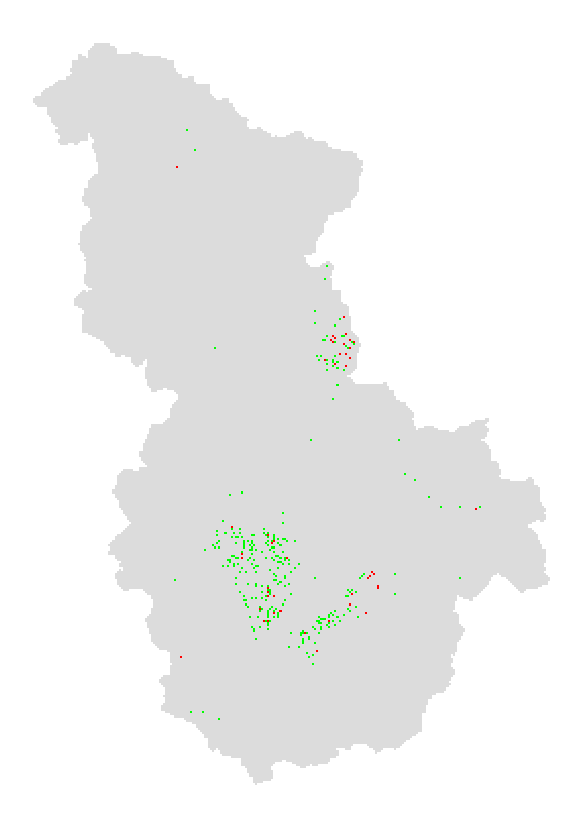

In [91]:
catb_sum = sejong.copy()
catb_sum['FN'] = catb_df[5]['FN'] + catb_df[7]['FN'] + catb_df[11]['FN'] + catb_df[14]['FN']

print('catboost 모델들이 중복 추천한 격자 수 :', len(catb_sum[catb_sum['FN']>1]))
fig, ax1 = plt.subplots(figsize=(15, 15))
fig.set_facecolor('white')
sejong['geometry'].plot(ax=ax1, color='gainsboro')
sejong[sejong['EV']==1].plot(ax=ax1, column='EV', color='lime', aspect=1)
catb_sum[catb_sum['FN']>1].plot(ax=ax1, color='red', aspect=1)
ax1.set_axis_off()
plt.show()

In [ ]:
catb_clf[5].get_params()

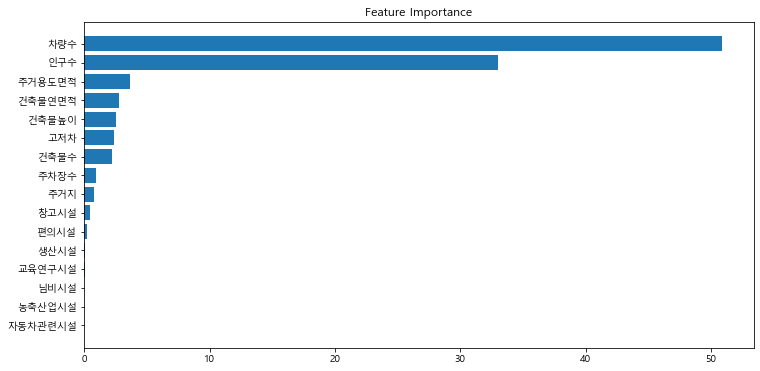

In [34]:
params = {'depth': 10,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS',
 'colsample_bylevel': 0.06276169135293053}

clf = catboost.CatBoostClassifier(**params)
clf.fit(train_data_rus, train_target_rus, verbose=0, early_stopping_rounds=100)
proba = clf.predict_proba(test_data)
preds = (proba[:,1] >= 0.6).astype('int')
feature_importance(clf)

### 결과 결합

In [ ]:
rf_sum = pd.read_csv('./rf_result.csv', encoding='cp949')
lgbm_sum = pd.read_csv('./lgbm_result.csv', encoding='cp949')
catb_sum = pd.read_csv('./catb_result.csv', encoding='cp949')

In [41]:
idx = rf_sum[rf_sum['FN']>2].index
rf_sum['rf_FN_dup'] = [0]*len(rf_sum)
for i in idx:
    rf_sum['rf_FN_dup'].loc[i] = 1
print(len(rf_sum[rf_sum['rf_FN_dup']==1]))

idx = lgbm_sum[lgbm_sum['FN']>2].index
lgbm_sum['lgbm_FN_dup'] = [0]*len(lgbm_sum)
for i in idx:
    lgbm_sum['lgbm_FN_dup'].loc[i] = 1
print(len(lgbm_sum[lgbm_sum['lgbm_FN_dup']==1]))

idx = catb_sum[catb_sum['FN']>2].index
catb_sum['catb_FN_dup'] = [0]*len(catb_sum)
for i in idx:
    catb_sum['catb_FN_dup'].loc[i] = 1
print(len(catb_sum[catb_sum['catb_FN_dup']==1]))

44
29
25


In [81]:
result = sejong.copy()
result['rf_FN_dup'] = rf_sum['rf_FN_dup']
result['lgbm_FN_dup'] = lgbm_sum['lgbm_FN_dup']
result['catb_FN_dup'] = catb_sum['catb_FN_dup']
result['all_FN_dup'] = rf_sum['rf_FN_dup'] + lgbm_sum['lgbm_FN_dup'] + catb_sum['catb_FN_dup']

In [82]:
print('세 모델 중 한 모델이 추천한 곳 :', len(result[result['all_FN_dup']==1]))
print('세 모델 중 두 모델이 추천한 곳 :', len(result[result['all_FN_dup']==2]))
print('세 모델 중 세 모델이 추천한 곳 :', len(result[result['all_FN_dup']==3]))

세 모델 중 한 모델이 추천한 곳 : 60
세 모델 중 두 모델이 추천한 곳 : 16
세 모델 중 세 모델이 추천한 곳 : 2


In [89]:
result['one_model_select'] = [0] * len(result)
result['two_model_select'] = [0] * len(result)
result['three_model_select'] = [0] * len(result)

idx = result[result['all_FN_dup']>=1].index
for i in idx:
    result['one_model_select'].loc[i] = 1
    
idx = result[result['all_FN_dup']>=2].index
for i in idx:
    result['two_model_select'].loc[i] = 1
    
idx = result[result['all_FN_dup']>=3].index
for i in idx:
    result['three_model_select'].loc[i] = 1

### 전기차 충전소 최적 입지 선정 결과

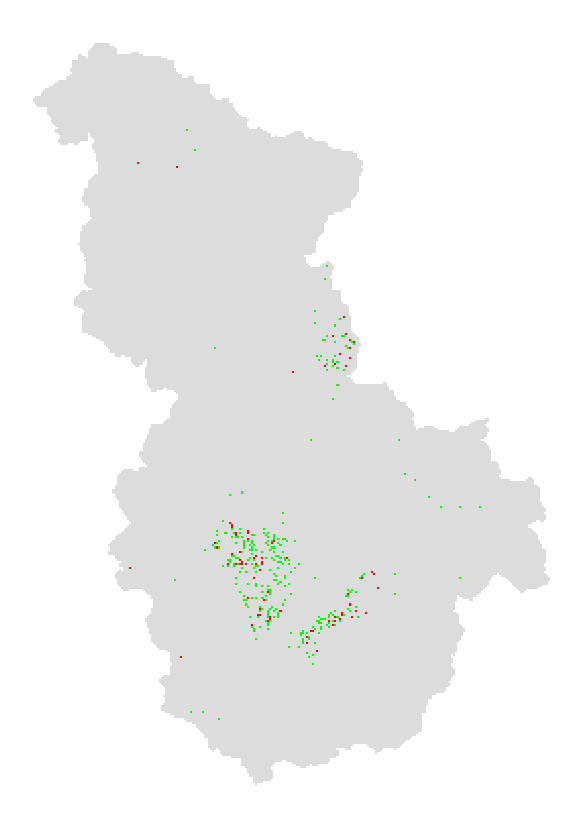

In [90]:
## 하나의 모델만 선택한 경우, 60
map_visualization(result[result.columns[:-2]])

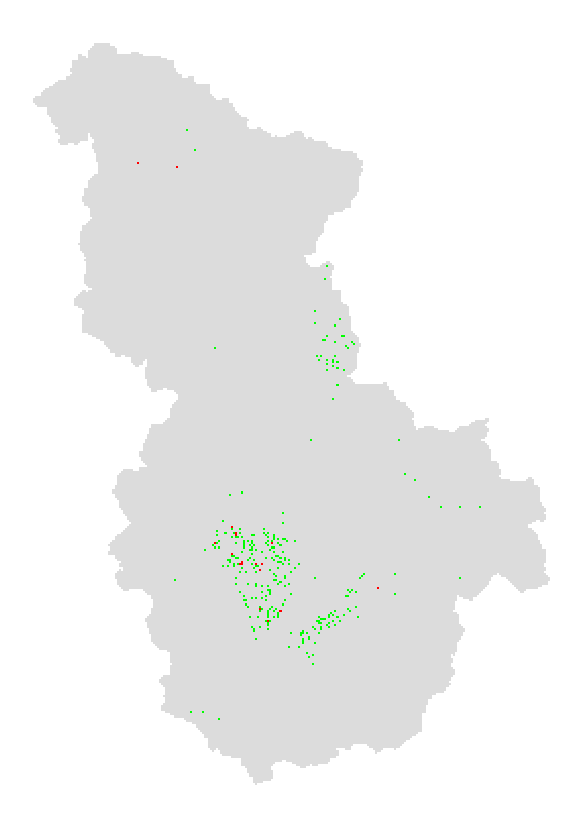

In [91]:
## 두 개의 모델이 선택한 경우, 16
map_visualization(result[result.columns[:-1]])

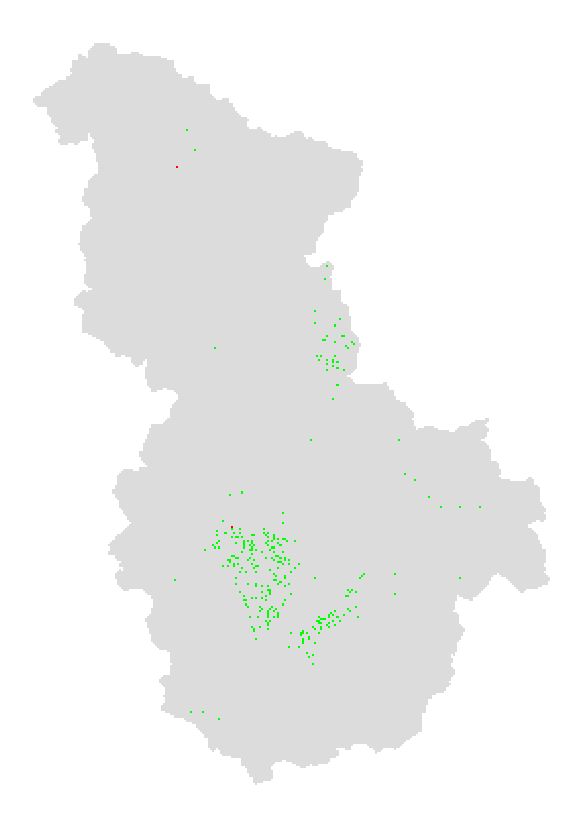

In [92]:
## 세 개의 모델이 선택한 경우, 2
map_visualization(result)

In [96]:
result = result[['geometry', 'lat', 'lng', '고저차', '인구수', '건축물수', '차량수', '주거용도면적',
       '건축물높이', '건축물연면적', '주차장수', '교육연구시설', '주거지', '농축산업시설', '창고시설', '편의시설',
       '생산시설', '님비시설', '자동차관련시설', 'EV', 'rf_FN_dup', 'lgbm_FN_dup',
       'catb_FN_dup', 'one_model_select', 'two_model_select',
       'three_model_select']]

result.to_csv('./dataset/전처리후/세종시_전기차_최적입지선정.csv', encoding='cp949')

### 지도 시각화

In [93]:
geo = geopandas.read_file('./dataset/전처리전/전국_읍면동_경계.geojson', encoding='utf-8')
geo = geo[geo['sidonm'] == '세종특별자치시']
geo['color'] = [0]*22

In [98]:
m = folium.Map(location=(36.57026017312205, 127.26846706447992), zoom_start=11)
    
heatMap = HeatMap(zip(result['lat'], result['lng'], result['인구수']),
                min_opacity=0.05,
                max_val=5,
                radius=5, blur=3,
                max_zoom=10,color='red')

m.add_child(heatMap)
#m.save('heatmap_세종_인구수.html')
m

### 기존 충전소 위치

In [241]:
# Draw a basemap
m = folium.Map(location=(36.57026017312205, 127.26846706447992), tiles='cartodbpositron', zoom_start=11)

folium.GeoJson(geo, name = 'json_data').add_to(m)

# Add  points to the map

mc = MarkerCluster()
for i in result[result['EV']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']])
    )
    
m.add_child(mc)

# Display the map
#m
m.save('현재_설치된_충전소_위치.html')

### 모델별 입지 시각화

In [107]:
# Draw a basemap
m = folium.Map(location=(36.57026017312205, 127.26846706447992), tiles='cartodbpositron', zoom_start=11)

folium.GeoJson(geo, name = 'json_data').add_to(m)

# Add  points to the map

mc = MarkerCluster()
for i in result[result['catb_FN_dup']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']])
    )
    
m.add_child(mc)

# Display the map
m
#m.save('CatBoost_결과.html')

### 최적 입지와 현재 충전소 위치 비교

In [135]:
# Draw a basemap
m = folium.Map(location=(36.57026017312205, 127.26846706447992), tiles='cartodbpositron', zoom_start=11)

folium.GeoJson(geo, name = 'json_data').add_to(m)

# Add  points to the map
mc = MarkerCluster()
for i in result[result['catb_FN_dup']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']],
              icon=folium.Icon(color='blue', icon='thumbs-up', prefix='fa'))
    )
    
m.add_child(mc)

mc = MarkerCluster()
for i in result[result['EV']==1].index:
    mc.add_child(    
        Marker(location = [result.loc[i]['lat'], result.loc[i]['lng']],
              icon=folium.Icon(color='red', icon='flash', prefix='fa'))
    )
    
m.add_child(mc)

# Display the map
m
#m.save('현_충전소와_최적입지_비교.html')

### Pydeck 3D 시각화

#### 정규화 및 좌표계 변경

In [149]:
sejong_scaling = sejong.copy()
sejong_scaling_minmax = scaler.fit_transform(sejong[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']])
sejong_scaling_minmax = pd.DataFrame(sejong_scaling_minmax, columns=['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차'])
sejong_scaling[['인구수', '건축물수', '차량수', '주거용도면적', '건축물높이', '건축물연면적', '고저차']] = sejong_scaling_minmax

In [180]:
geometry = sejong_scaling['geometry'].astype(str)

length_100m = (36.73376199366808 - 36.40675835257603) / 364
width_100m = (127.4092754044858 - 127.12765872447403) / 254

co = []

for g in geometry:
    temp1 = []
    for t in g.split('((')[1].split('))')[0].split(', '):
        temp2 = []
        temp2.append((int(t.split()[0]) - 966700) / 100 * width_100m + 127.12765872447403)
        temp2.append((int(t.split()[1]) - 1823200) / 100 * length_100m + 36.40675835257603)
        temp1.append(temp2)
    co.append(temp1)

sejong_scaling['coordinates'] = co

#### pydeck params

In [189]:
view_state = pydeck.ViewState(
    latitude=36.57026017312205,
    longitude=127.26846706447992,
    zoom=11,
    max_zoom=20,
    pitch=45,
    bearing=0)

In [236]:
layer = pydeck.Layer(
    'PolygonLayer',
    sejong_scaling[sejong_scaling['인구수정규화']>0],
    get_polygon='coordinates',
    #get_position='[lng, lat]',
    auto_highlight=True,
    elevation_scale=5000,
    #elevation_range=[0, 3000],
    pickable=True,
    #get_fill_color='[0, 255*인구수정규화, 0]',
    get_fill_color='[200, 100, 150, 140]',
    extruded = True,
    get_elevation = '인구수정규화',
)

In [238]:
r = pydeck.Deck(
    map_style='light',
    layers=layer,
    initial_view_state=view_state)

r
#r.to_html('./시각화/pydeck_인구수.html')